In [135]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
import http.client, urllib.request, urllib.parse, urllib.error, base64
#import config
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [136]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [137]:
from pydrive.auth import GoogleAuth

codebk = drive.CreateFile({'id': '1Lf7kV9_R-caFZV6_l8hMxAVjFSVFhvYl'})
codebk.GetContentFile('codebook.xlsx')  

codebk= pd.read_excel('codebook.xlsx', sheet_name = "predictors")
codebk.head()

/Users/bayerd01/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variable,Description,Source,Notes,Include_BBL,Include_Box
0,geofips,census tract geo identifier,Census ACS,NaN,0.0,0.0
1,geofips_recode,"census tract geo identifier, changes county to...",Census ACS,NaN,0.0,0.0
2,totpop,total population,Census ACS,NaN,1.0,1.0
3,popdens,total population per square mile,Census ACS,NaN,1.0,1.0
4,areasqmile,area,Census ACS,NaN,1.0,1.0


In [140]:
predictors_full = codebk.loc[codebk["Include_Box"] == 1, "Variable"].apply(lambda x: x.strip())
predictors_full

2            totpop
3           popdens
4        areasqmile
5             males
6           females
           ...     
164    bldgclass_A2
165    bldgclass_A0
166    bldgclass_A6
167    bldgclass_A8
168    bldgclass_CM
Name: Variable, Length: 150, dtype: object

In [138]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


## Load Analysis Box File

In [139]:
df_box = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
df_box.GetContentFile('analysis_box.csv')  

df_box= pd.read_csv('analysis_box.csv').drop(["Unnamed: 0"], axis = 1)
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdsamecounty,pctmvdsdiffcounty,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,3.130277,0.0,0.0,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,3.130277,0.0,0.0,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,3.130277,0.0,0.0,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,3.130277,0.0,0.0,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,3.130277,0.0,0.0,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333


## PART I: CLUSTER ANALYSIS WITHOUT TARGET VARIABLE (PREDICTION)

#### A. DATA PREP

In [180]:
predictors = df_box[['totpop','popdens','areasqmile','males','females','pop18under','pop18_34','pop35_64','pop65plus'
                     ,'pophispanic','popnhwhite','popnhblack','popnhaian','popnhasian','popnhhawainpi','popnhother'
                     ,'popnhtwoplus','housing','housingoccupied','renterhousing','oc_halfless','oc_half_1'
                     ,'oc_1_onehalf','oc_onehalf_2','oc_2plus','roc_halfless','roc_half_1','roc_1_onehalf'
                     ,'roc_onehalf_2','roc_2plus','medianyearbuilt','mediangrossrent','medianhhincome','gini'
                     ,'pct18under','pct18_34','pct35_64','pct65plus','pcthispanic','pctnhwhite','pctnhblack'
                     ,'pctnhaian','pctnhasian','pctnhhawainpi','pctnhother','pctnhtwoplus','pctownerocch','pctrentocch'
                     ,'crowding','crowdingrenter','pctmale','pcthgas','pcthelectricity','pcthoilker','pcthcoal'
                     ,'pcthsolar','pcthotherf','pcthnofuel','pctsamehouse','pctmvdsamecounty','pctmvdsdiffcounty'
                     ,'pctmvdsdiffstate','pctmvdabroad','pop1yrplusinhh','pctpoprenterhh','AL','NB','tot_hpd_vio'
                     ,'hpd_fire_vio','hpd_b_c_vio','viol_count_per_unit','hpd_fire_vio_per_unit'
                     ,'hpd_b_c_vio_per_unit','average_energy_usage','lotarea','bldgarea','numbldgs','numfloors'
                     ,'unitsres','unitstotal','assessland','assesstot','exempttot','yearbuilt'
                    #,"dispatch_response_seconds_qy", "num_fire_ev", "avg_fire_ev_yr"
                    ]]
predictors


,totpop,popdens,areasqmile,males,females,pop18under,pop18_34,pop35_64,pop65plus,pophispanic,...,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt
0,192.829384,1475.321374,0.007124,94.180095,98.649289,20.819905,81.208531,67.310427,23.490521,12.154028,...,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,1929.000000
1,414.105781,1448.498316,0.017049,212.526422,201.579359,70.760868,151.051374,168.213951,24.079588,60.337928,...,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,1995.750000
2,706.381766,4940.829858,0.018737,347.293447,359.088319,104.843305,257.259259,266.170940,78.108262,191.732194,...,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,1930.347826
3,61.424501,429.637379,0.001629,30.199430,31.225071,9.116809,22.370370,23.145299,6.792023,16.672365,...,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,1958.250000
4,1335.982906,9344.612991,0.035437,656.837607,679.145299,198.290598,486.555556,503.410256,147.726496,362.623932,...,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,1929.057471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,818.000000,5340.100000,0.021883,397.428571,420.571429,182.285714,136.428571,256.571429,242.714286,86.428571,...,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,1978.666667
10860,120.461233,583.174647,0.013550,56.239849,64.221384,19.767547,41.797635,37.549132,21.346918,23.916176,...,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,1788.615385
10861,300.394667,1285.501374,0.023265,143.582545,156.812121,40.904848,125.027758,94.842667,39.619394,84.940848,...,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,1931.714286
10862,110.443810,674.581238,0.007173,54.236190,56.207619,23.131429,21.335238,39.998095,25.979048,26.066667,...,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,1958.913043


In [106]:
predictors = df_box.loc[:, predictors_full].fillna(0)

#### JUST FEATURE IMPORTANCE FIELDS:

In [74]:
imp_feat = ["hpd_b_c_vio", "bldgarea", "tot_hpd_vio", "hpd_b_c_vio_per_unit", "unitstotal", "pop65plus",
           "unitsres","pctnhblack","hpd_fire_vio","mediangrossrent"]


In [75]:
imp_feat = df_box.loc[:, imp_feat].fillna(0)

In [76]:
imp_feat

,hpd_b_c_vio,bldgarea,tot_hpd_vio,hpd_b_c_vio_per_unit,unitstotal,pop65plus,unitsres,pctnhblack,hpd_fire_vio,mediangrossrent
0,7.739130,9239.391304,14.608696,0.957782,9.043478,431.000000,9.000000,5.907292,0.086957,2093.000000
1,1.125000,209572.375000,3.750000,0.010057,231.125000,568.750000,229.750000,5.007916,0.000000,2170.250000
2,4.586957,4832.108696,8.804348,0.712707,5.847826,596.000000,5.695652,5.176252,0.108696,2027.000000
3,0.000000,85292.250000,3.750000,0.000000,102.000000,596.000000,101.500000,5.176252,0.000000,2027.000000
4,9.632184,8242.965517,16.114943,1.405932,7.402299,596.000000,7.080460,5.176252,0.183908,2027.000000
...,...,...,...,...,...,...,...,...,...,...
10859,4.500000,31399.111111,7.333333,0.025093,27.666667,1699.000000,22.944444,10.495983,0.000000,1963.000000
10860,22.000000,50165.000000,30.230769,0.940423,40.230769,388.769231,40.230769,5.998493,0.153846,1602.384615
10861,0.000000,3360.285714,0.000000,0.000000,1.047619,407.428571,1.047619,6.467723,0.000000,1647.571429
10862,0.000000,11903.260870,0.000000,0.000000,11.869565,593.000000,11.869565,4.839349,0.000000,1720.000000


#### B. STANDARDIZE DATA

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [181]:
#standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(predictors)
scaled_features

array([[-0.66232856, -0.56233208, -0.36603422, ..., -0.0749955 ,
        -0.09695783, -0.12125777],
       [-0.40989416, -0.56409362, -0.15306751, ...,  1.3172487 ,
         0.28925794,  0.94093529],
       [-0.0764627 , -0.33474266, -0.11686103, ..., -0.11349272,
        -0.09046373, -0.0998098 ],
       ...,
       [-0.53961697, -0.57479808, -0.01969621, ..., -0.164321  ,
        -0.09358177, -0.07806533],
       [-0.75631487, -0.61491887, -0.36498408, ..., -0.14121122,
        -0.05902213,  0.35474863],
       [-0.3866916 , -0.53191743,  0.03971918, ..., -0.16731125,
        -0.09656585,  0.1610251 ]])

In [77]:
#standardize important features
scaler = StandardScaler()
scaled_imp_feat = scaler.fit_transform(imp_feat)
scaled_imp_feat

array([[-0.07805414, -0.08982108, -0.02769542, ..., -0.54101698,
        -0.07672059,  1.12512999],
       [-0.20750589,  1.00262214, -0.17982252, ..., -0.5744407 ,
        -0.28742755,  1.293378  ],
       [-0.13974849, -0.11385459, -0.10901261, ..., -0.56818478,
        -0.02404385,  0.98138412],
       ...,
       [-0.22952439, -0.12188064, -0.2323589 , ..., -0.52018954,
        -0.28742755,  0.15500094],
       [-0.22952439, -0.07529463, -0.2323589 , ..., -0.58070518,
        -0.28742755,  0.31274803],
       [-0.22697152, -0.12492885, -0.22748596, ..., -0.51412106,
        -0.28742755,  0.21473948]])

#### C. K-MEANS:

In [182]:
#determine the number of clusters using the silhouette score - all predictors
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_features)    
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.49378610286561925
For n_clusters = 3, the average silhouette_score is : 0.3673997989553567
For n_clusters = 4, the average silhouette_score is : 0.347322528546816
For n_clusters = 5, the average silhouette_score is : 0.3629767498102362
For n_clusters = 6, the average silhouette_score is : 0.36970432911868845
For n_clusters = 7, the average silhouette_score is : 0.26029051933734065
For n_clusters = 8, the average silhouette_score is : 0.26138159564824875
For n_clusters = 9, the average silhouette_score is : 0.24516832143205333


[1168103.343769411, 1111048.6721526028, 1069028.1672530274, 1037098.1269559542, 1011069.533972782, 988903.8165890825, 971784.5041796678, 957921.4008644883]


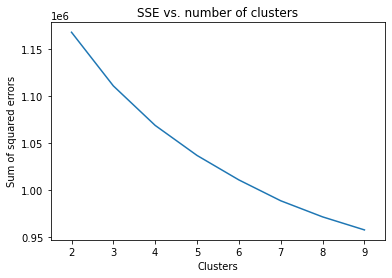

In [153]:
# As an alternative, look for an elbow in the within-cluster SSE (k-means example):
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(scaled_features)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.show()

Cluster assignments: [0 0 0 ... 0 0 0]

Cluster centers:
 [[-3.15020599e-01 -2.97627720e-01 -6.35860576e-02 -3.12586412e-01
  -3.14032791e-01 -2.92017231e-01 -3.00553735e-01 -3.04653152e-01
  -2.60958898e-01 -2.46557980e-01 -1.87011657e-01 -1.66977077e-01
  -8.44206579e-02 -1.52703611e-01 -4.71860785e-02 -5.13464020e-02
  -2.15098934e-01 -3.00197157e-01 -1.61861829e-01 -3.04623878e-01
  -2.69531200e-01 -3.03701676e-01 -2.63908489e-01 -2.63409039e-01
  -2.18921929e-01 -2.77741243e-01 -3.04141317e-01 -2.60641021e-01
  -2.59184601e-01 -2.11565538e-01  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  -1.00000000e+00  0.00000000e+00 -1.00000000e+00 -1.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.49865536e-01
  -7.87538156e-02 -1.26879668e-01 -3.51954647e-04  1.54224478e-02
  -8.42903335e-02 

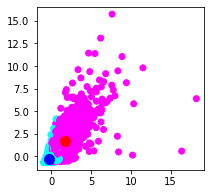

In [183]:
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(scaled_features)

print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

# plot points and cluster assigments
plt.figure(figsize=(3,3))
plt.scatter(scaled_features[:,0],scaled_features[:,1],c=res.labels_,cmap=plt.cm.cool)
plt.scatter(res.cluster_centers_[0,0],res.cluster_centers_[0,1],c="b",s=100)
plt.scatter(res.cluster_centers_[1,0],res.cluster_centers_[1,1],c="r",s=100)
plt.show()

In [184]:
#adding clusters to dataframe
df_box['cluster_just_predictors'] = res.labels_
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster_just_predictors,cluster_k_outcome
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,0.0,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000,0,1
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,0.0,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000,0,1
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,0.0,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077,0,1
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,0.0,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667,0,1
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,0.0,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333,1,0


In [185]:
all_predictors = pd.merge(df_box, borobox, how='inner', on='borobox')

all_predictors

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster_just_predictors,cluster_k_outcome,geometry
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000,0,1,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000,0,1,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077,0,1,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667,0,1,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333,1,0,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,X4978,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,...,0.948175,1.0,2.696970,1.878788,46.303030,33,2.357143,0,1,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,...,0.948175,1.0,3.083333,2.166667,29.333333,12,1.333333,0,1,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,...,0.948175,1.0,2.000000,1.333333,59.666667,3,1.000000,0,1,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,...,0.948175,1.0,3.000000,2.666667,48.333333,3,1.500000,0,1,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


In [186]:
all_predictors = gpd.GeoDataFrame(all_predictors, geometry='geometry')

<AxesSubplot:>

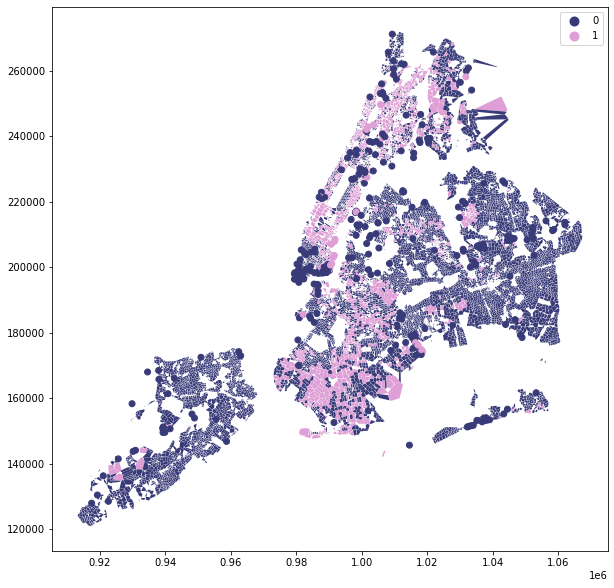

In [187]:
fig, ax = plt.subplots(1, figsize=(15,10))
all_predictors.plot(column='cluster_just_predictors',categorical=True, ax=ax, legend=True, cmap='tab20b')

In [78]:
#IMPORTANT FEATURES ONLY

#determine the number of clusters using the silhouette score 
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_imp_feat)    
    silhouette_avg = silhouette_score(scaled_imp_feat, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.9557346539239623
For n_clusters = 3, the average silhouette_score is : 0.5831039924564787
For n_clusters = 4, the average silhouette_score is : 0.3467226935974147
For n_clusters = 5, the average silhouette_score is : 0.35358498240694525
For n_clusters = 6, the average silhouette_score is : 0.35390705336186096
For n_clusters = 7, the average silhouette_score is : 0.28872560879988396
For n_clusters = 8, the average silhouette_score is : 0.3168866534470009
For n_clusters = 9, the average silhouette_score is : 0.3346877236550937


Cluster assignments: [0 0 0 ... 0 0 0]

Cluster centers:
 [[-1.59348722e-02 -1.50844665e-02 -1.70342354e-02 -1.26558505e-03
  -1.58555672e-02 -1.95746941e-03 -1.58801414e-02 -5.62602731e-04
  -4.27840190e-03  4.17624585e-04]
 [ 2.47149868e+01  2.33960075e+01  2.64200992e+01  1.96292242e+00
   2.45919848e+01  3.03603506e+00  2.46300992e+01  8.72596836e-01
   6.63580134e+00 -6.47735731e-01]]

Sum of squared errors: 86744.46391628527


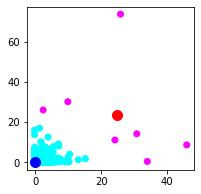

In [79]:
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(scaled_imp_feat)

print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

# plot points and cluster assigments
plt.figure(figsize=(3,3))
plt.scatter(scaled_imp_feat[:,0],scaled_imp_feat[:,1],c=res.labels_,cmap=plt.cm.cool)
plt.scatter(res.cluster_centers_[0,0],res.cluster_centers_[0,1],c="b",s=100)
plt.scatter(res.cluster_centers_[1,0],res.cluster_centers_[1,1],c="r",s=100)
plt.show()

In [80]:
#adding clusters to dataframe
df_box['cluster'] = res.labels_
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,17.874693,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000,0
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,10.082423,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000,0
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,9.965636,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077,0
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,9.965636,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667,0
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,9.965636,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333,0


In [82]:
#merge to geojson

EM_IMP_FEAT = pd.merge(df_box, borobox, how='inner', on='borobox')

EM_IMP_FEAT

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,geometry
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000,0,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000,0,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077,0,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667,0,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333,0,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,X4978,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,...,57.828482,0.511408,0.884354,2.696970,1.878788,46.303030,33,2.357143,0,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,...,44.068432,1.848746,4.064422,3.083333,2.166667,29.333333,12,1.333333,0,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,...,45.685366,1.173006,2.671453,2.000000,1.333333,59.666667,3,1.000000,0,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,...,36.919592,4.530011,10.122699,3.000000,2.666667,48.333333,3,1.500000,0,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


In [85]:
EM_IMP_FEAT = gpd.GeoDataFrame(EM_IMP_FEAT, geometry='geometry')

<AxesSubplot:>

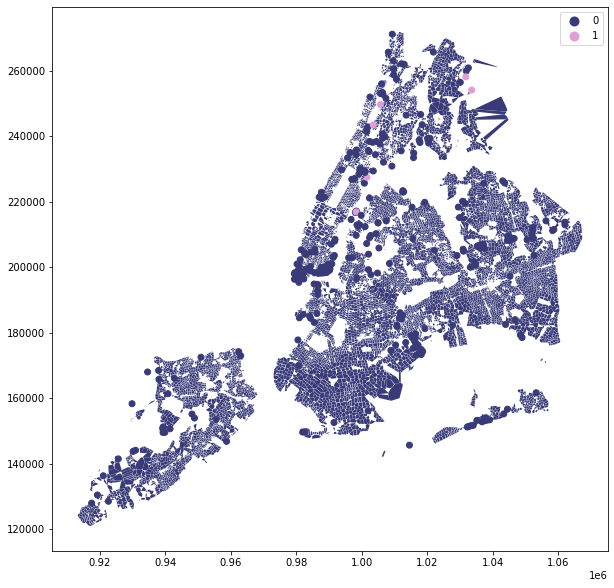

In [102]:
fig, ax = plt.subplots(1, figsize=(15,10))
EM_IMP_FEAT.plot(column='cluster',categorical=True, ax=ax, legend=True, cmap='tab20b')

In [104]:
EM_IMP_FEAT.loc[EM_IMP_FEAT['cluster'] == 1]

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,geometry
3167,M1331,519220.0,2046455.0,4.0,31.0,1594.0,1604.0,14490450.0,70344900.0,70344900.0,...,89.892729,7.032181,6.974277,0.000000,0.000000,0.000000,1,0.000000,1,POINT (1001506.184 227424.063)
3564,M1947,4231466.0,4786701.0,38.0,18.0,8018.0,8088.0,134506350.0,443556000.0,443556000.0,...,66.277518,11.774516,15.299446,3.090909,2.272727,103.181818,11,1.833333,1,POINT (998234.893 216886.338)
9869,X2520,19887.0,89457.0,1.0,6.0,94.0,95.0,134100.0,1864350.0,0.0,...,99.146067,11.550562,11.650045,0.000000,0.000000,0.000000,2,0.000000,1,POINT (1003463.472 243424.723)
10126,X3007,1449960.5,2610900.0,50.5,6.5,3617.5,3617.5,14354178.0,73357775.5,39746578.0,...,79.129228,12.466692,12.044988,3.250000,2.230769,34.211538,52,3.058824,1,"LINESTRING (1023303.109 245551.148, 1023849.55..."
10723,X4382,1952770.0,5541031.0,37.0,33.0,4458.0,4470.0,17574750.0,109098900.0,109098900.0,...,49.792835,4.655130,3.279491,3.158730,2.063492,36.301587,63,3.705882,1,POINT (1033495.426 254073.763)
10763,X4487,5048550.0,13540113.0,250.0,33.0,10914.0,10948.0,25285500.0,204495300.0,204495300.0,...,54.569934,5.585475,6.964613,3.210526,2.110526,32.584211,190,11.176471,1,POINT (1031717.850 258115.476)
10790,X4723,856800.0,1597950.0,6.0,44.0,1654.0,1660.0,11566800.0,49701600.0,49701600.0,...,100.000000,8.837485,8.837485,3.353659,2.271777,34.512195,574,33.764706,1,POINT (1005649.494 249646.724)


#### D. GAUSSIAN MIXTURE

In [160]:
# ALL PREDICTORS
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_features)    
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.28409441986322703
For n_clusters = 3, the average silhouette_score is : 0.16248711601753482
For n_clusters = 4, the average silhouette_score is : 0.15884914622769125
For n_clusters = 5, the average silhouette_score is : 0.10450643166053655
For n_clusters = 6, the average silhouette_score is : 0.04289965789994492
For n_clusters = 7, the average silhouette_score is : 0.04481945115670551
For n_clusters = 8, the average silhouette_score is : 0.09210126845919323
For n_clusters = 9, the average silhouette_score is : 0.05690788638306776


In [161]:
gmm = GaussianMixture(n_components=2,random_state=234)
res = gmm.fit(scaled_features)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(scaled_features)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(scaled_features))

Probabilities of belonging to cluster 1:
 [1.00000000e+000 1.00000000e+000 1.87316804e-037 ... 2.01451165e-145
 1.95221680e-044 2.21171601e-113]

Cluster centers:
 [[-1.70048033e-01 -2.01353178e-01  3.47154268e-03 -1.65545832e-01
  -1.72346492e-01 -1.27102913e-01 -1.97632108e-01 -1.54228288e-01
  -1.41534767e-01 -1.51191575e-01 -1.42564301e-01 -5.50801132e-02
  -3.71725859e-02 -2.56477244e-02 -4.92780932e-02  3.21065853e-02
  -1.18080303e-01 -2.00748095e-01 -2.79119035e-02 -2.36285654e-01
  -1.90722846e-01 -2.02015730e-01 -1.12121509e-01 -1.72606170e-01
  -1.03528916e-01 -2.31177247e-01 -2.35370111e-01 -1.32226783e-01
  -1.74873252e-01 -1.06013344e-01  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  -1.00000000e+00  0.00000000e+00 -1.00000000e+00 -1.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.0000000

In [64]:
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_imp_feat)    
    silhouette_avg = silhouette_score(scaled_imp_feat, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.9557346539239623
For n_clusters = 3, the average silhouette_score is : 0.9481707781380376
For n_clusters = 4, the average silhouette_score is : 0.20039694391268834
For n_clusters = 5, the average silhouette_score is : 0.011789194911679948
For n_clusters = 6, the average silhouette_score is : -0.01650472989338079
For n_clusters = 7, the average silhouette_score is : -0.0057871077268662075
For n_clusters = 8, the average silhouette_score is : 0.034979471349925975
For n_clusters = 9, the average silhouette_score is : -0.013464545906781228


In [65]:
gmm = GaussianMixture(n_components=2,random_state=100)
res = gmm.fit(scaled_imp_feat)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(scaled_imp_feat)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(scaled_imp_feat))

Probabilities of belonging to cluster 1:
 [0.9999998  0.         1.         ... 1.         0.01571035 1.        ]

Cluster centers:
 [[ 0.52214509  0.32634126  0.51078997  0.67922246  0.33211184  0.2733006
   0.32623198  0.00661706  0.64174232  0.03698521]
 [-0.20016691 -0.12510454 -0.19581388 -0.2603833  -0.12731672 -0.10477114
  -0.12506265 -0.00253668 -0.24601511 -0.01417847]]

Cluster covariances:
 [[[ 3.22444898e+00  1.22502493e+00  3.16454348e+00  1.10003014e+00
    1.19088881e+00  1.25078849e-01  1.19764895e+00  2.42393134e-01
    1.83064757e+00 -5.29137164e-01]
  [ 1.22502493e+00  3.46099046e+00  1.67889303e+00 -3.74603681e-01
    3.24804775e+00  5.86773294e-01  3.25056680e+00  4.94170648e-02
   -1.67365901e-01 -2.65831907e-02]
  [ 3.16454348e+00  1.67889303e+00  3.23942583e+00  9.57217383e-01
    1.57860938e+00  2.30728355e-01  1.58603999e+00  2.32258451e-01
    1.62089332e+00 -4.94037453e-01]
  [ 1.10003014e+00 -3.74603681e-01  9.57217383e-01  2.44378961e+00
   -3.71463774e-0

## PART II: CLUSTER ANALYSIS WITH TARGET VARIABLE (RELATIONSHIPS BETWEEN DATA)

In [164]:
df_box

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdsdiffcounty,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster_just_predictors
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,0.0,0.0,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000,0
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,0.0,0.0,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000,0
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,0.0,0.0,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077,0
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,0.0,0.0,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667,0
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,0.0,0.0,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,X4978,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,...,0.0,0.0,0.948175,1.0,2.696970,1.878788,46.303030,33,2.357143,0
10860,X4981,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,...,0.0,0.0,0.948175,1.0,3.083333,2.166667,29.333333,12,1.333333,0
10861,X4982,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,...,0.0,0.0,0.948175,1.0,2.000000,1.333333,59.666667,3,1.000000,0
10862,X4985,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,...,0.0,0.0,0.948175,1.0,3.000000,2.666667,48.333333,3,1.500000,0


In [168]:
df_box_all = df_box[['totpop','popdens','areasqmile','males','females','pop18under','pop18_34','pop35_64','pop65plus'
                     ,'pophispanic','popnhwhite','popnhblack','popnhaian','popnhasian','popnhhawainpi','popnhother'
                     ,'popnhtwoplus','housing','housingoccupied','renterhousing','oc_halfless','oc_half_1'
                     ,'oc_1_onehalf','oc_onehalf_2','oc_2plus','roc_halfless','roc_half_1','roc_1_onehalf'
                     ,'roc_onehalf_2','roc_2plus','medianyearbuilt','mediangrossrent','medianhhincome','gini'
                     ,'pct18under','pct18_34','pct35_64','pct65plus','pcthispanic','pctnhwhite','pctnhblack'
                     ,'pctnhaian','pctnhasian','pctnhhawainpi','pctnhother','pctnhtwoplus','pctownerocch','pctrentocch'
                     ,'crowding','crowdingrenter','pctmale','pcthgas','pcthelectricity','pcthoilker','pcthcoal'
                     ,'pcthsolar','pcthotherf','pcthnofuel','pctsamehouse','pctmvdsamecounty','pctmvdsdiffcounty'
                     ,'pctmvdsdiffstate','pctmvdabroad','pop1yrplusinhh','pctpoprenterhh','AL','NB','tot_hpd_vio'
                     ,'hpd_fire_vio','hpd_b_c_vio','viol_count_per_unit','hpd_fire_vio_per_unit'
                     ,'hpd_b_c_vio_per_unit','average_energy_usage','lotarea','bldgarea','numbldgs','numfloors'
                     ,'unitsres','unitstotal','assessland','assesstot','exempttot','yearbuilt'
                    ,"dispatch_response_seconds_qy", "num_fire_ev", "avg_fire_ev_yr"]]
df_box_all

,totpop,popdens,areasqmile,males,females,pop18under,pop18_34,pop35_64,pop65plus,pophispanic,...,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,192.829384,1475.321374,0.007124,94.180095,98.649289,20.819905,81.208531,67.310427,23.490521,12.154028,...,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,1929.000000,32.666667,6,1.200000
1,414.105781,1448.498316,0.017049,212.526422,201.579359,70.760868,151.051374,168.213951,24.079588,60.337928,...,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,1995.750000,42.333333,3,3.000000
2,706.381766,4940.829858,0.018737,347.293447,359.088319,104.843305,257.259259,266.170940,78.108262,191.732194,...,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,1930.347826,36.880000,25,1.923077
3,61.424501,429.637379,0.001629,30.199430,31.225071,9.116809,22.370370,23.145299,6.792023,16.672365,...,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,1958.250000,15.600000,5,1.666667
4,1335.982906,9344.612991,0.035437,656.837607,679.145299,198.290598,486.555556,503.410256,147.726496,362.623932,...,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,1929.057471,32.181818,44,2.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,818.000000,5340.100000,0.021883,397.428571,420.571429,182.285714,136.428571,256.571429,242.714286,86.428571,...,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,1978.666667,46.303030,33,2.357143
10860,120.461233,583.174647,0.013550,56.239849,64.221384,19.767547,41.797635,37.549132,21.346918,23.916176,...,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,1788.615385,29.333333,12,1.333333
10861,300.394667,1285.501374,0.023265,143.582545,156.812121,40.904848,125.027758,94.842667,39.619394,84.940848,...,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,1931.714286,59.666667,3,1.000000
10862,110.443810,674.581238,0.007173,54.236190,56.207619,23.131429,21.335238,39.998095,25.979048,26.066667,...,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,1958.913043,48.333333,3,1.500000


In [169]:
#standardize the data
scaler = StandardScaler()
scaled_all = scaler.fit_transform(df_box_all)
scaled_all

array([[-0.66232856, -0.56233208, -0.36603422, ..., -0.41455412,
        -0.45196265, -0.42184674],
       [-0.40989416, -0.56409362, -0.15306751, ...,  0.10798645,
        -0.51372908,  0.22092313],
       [-0.0764627 , -0.33474266, -0.11686103, ..., -0.18679851,
        -0.06077527, -0.16364004],
       ...,
       [-0.53961697, -0.57479808, -0.01969621, ...,  1.04495575,
        -0.51372908, -0.49326561],
       [-0.75631487, -0.61491887, -0.36498408, ...,  0.43232198,
        -0.51372908, -0.31471843],
       [-0.3866916 , -0.53191743,  0.03971918, ...,  1.02693711,
        -0.51372908, -0.49326561]])

In [73]:
#important features only
imp_feat = ["hpd_b_c_vio", "bldgarea", "tot_hpd_vio", "hpd_b_c_vio_per_unit", "unitstotal", "pop65plus",
           "unitsres","pctnhblack","hpd_fire_vio","mediangrossrent", 'num_fire_ev', 'avg_fire_ev_yr']

imp_feat = df_box.loc[:, imp_feat].fillna(0)
imp_feat

,hpd_b_c_vio,bldgarea,tot_hpd_vio,hpd_b_c_vio_per_unit,unitstotal,pop65plus,unitsres,pctnhblack,hpd_fire_vio,mediangrossrent,num_fire_ev,avg_fire_ev_yr
0,7.739130,9239.391304,14.608696,0.957782,9.043478,431.000000,9.000000,5.907292,0.086957,2093.000000,6,1.200000
1,1.125000,209572.375000,3.750000,0.010057,231.125000,568.750000,229.750000,5.007916,0.000000,2170.250000,3,3.000000
2,4.586957,4832.108696,8.804348,0.712707,5.847826,596.000000,5.695652,5.176252,0.108696,2027.000000,25,1.923077
3,0.000000,85292.250000,3.750000,0.000000,102.000000,596.000000,101.500000,5.176252,0.000000,2027.000000,5,1.666667
4,9.632184,8242.965517,16.114943,1.405932,7.402299,596.000000,7.080460,5.176252,0.183908,2027.000000,44,2.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
10859,4.500000,31399.111111,7.333333,0.025093,27.666667,1699.000000,22.944444,10.495983,0.000000,1963.000000,33,2.357143
10860,22.000000,50165.000000,30.230769,0.940423,40.230769,388.769231,40.230769,5.998493,0.153846,1602.384615,12,1.333333
10861,0.000000,3360.285714,0.000000,0.000000,1.047619,407.428571,1.047619,6.467723,0.000000,1647.571429,3,1.000000
10862,0.000000,11903.260870,0.000000,0.000000,11.869565,593.000000,11.869565,4.839349,0.000000,1720.000000,3,1.500000


#### A. K-MEANS

In [170]:
#determine the number of clusters using the silhouette score
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_all)    
    silhouette_avg = silhouette_score(scaled_all, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.4759518948688823
For n_clusters = 3, the average silhouette_score is : 0.35204276734762
For n_clusters = 4, the average silhouette_score is : 0.3300545070790961
For n_clusters = 5, the average silhouette_score is : 0.3515460649239145
For n_clusters = 6, the average silhouette_score is : 0.3429602849468665
For n_clusters = 7, the average silhouette_score is : 0.24016471880198068
For n_clusters = 8, the average silhouette_score is : 0.26011555624180227
For n_clusters = 9, the average silhouette_score is : 0.16321210579993703


Cluster assignments: [1 1 1 ... 1 1 1]

Cluster centers:
 [[ 1.72096862e+00  1.63167278e+00  3.36321387e-01  1.70737356e+00
   1.71583599e+00  1.59551971e+00  1.64956207e+00  1.66119742e+00
   1.41892605e+00  1.35713158e+00  1.00983694e+00  9.24423797e-01
   4.57524291e-01  8.20316548e-01  2.60268305e-01  2.81184500e-01
   1.17304519e+00  1.64058345e+00  8.63656419e-01  1.67326039e+00
   1.47233477e+00  1.66039996e+00  1.44316320e+00  1.44051738e+00
   1.19488057e+00  1.52741128e+00  1.66963567e+00  1.42945543e+00
   1.41911698e+00  1.15680790e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  -1.00000000e+00  0.00000000e+00 -1.00000000e+00 -1.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -8.49873343e-01
   4.44330179e-01  7.22537623e-01  5.66290487e-03 -8.91007821e-02
   4.70637090e-01 

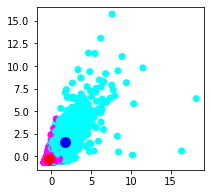

In [171]:
# Use k-means package from sklearn
from sklearn.cluster import KMeans
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(scaled_all)

print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

# plot points and cluster assigments
plt.figure(figsize=(3,3))
plt.scatter(scaled_all[:,0],scaled_all[:,1],c=res.labels_,cmap=plt.cm.cool)
plt.scatter(res.cluster_centers_[0,0],res.cluster_centers_[0,1],c="b",s=100)
plt.scatter(res.cluster_centers_[1,0],res.cluster_centers_[1,1],c="r",s=100)
plt.show()

In [172]:
#adding clusters to dataframe
df_box['cluster_k_outcome'] = res.labels_
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster_just_predictors,cluster_k_outcome
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,0.0,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000,0,1
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,0.0,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000,0,1
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,0.0,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077,0,1
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,0.0,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667,0,1
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,0.0,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333,1,0


In [173]:
#merge to geojson

k_outcomes = pd.merge(df_box, borobox, how='inner', on='borobox')

k_outcomes

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster_just_predictors,cluster_k_outcome,geometry
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000,0,1,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000,0,1,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077,0,1,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667,0,1,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333,1,0,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,X4978,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,...,0.948175,1.0,2.696970,1.878788,46.303030,33,2.357143,0,1,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,...,0.948175,1.0,3.083333,2.166667,29.333333,12,1.333333,0,1,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,...,0.948175,1.0,2.000000,1.333333,59.666667,3,1.000000,0,1,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,...,0.948175,1.0,3.000000,2.666667,48.333333,3,1.500000,0,1,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


In [174]:
k_outcomes = gpd.GeoDataFrame(k_outcomes, geometry='geometry')

<AxesSubplot:>

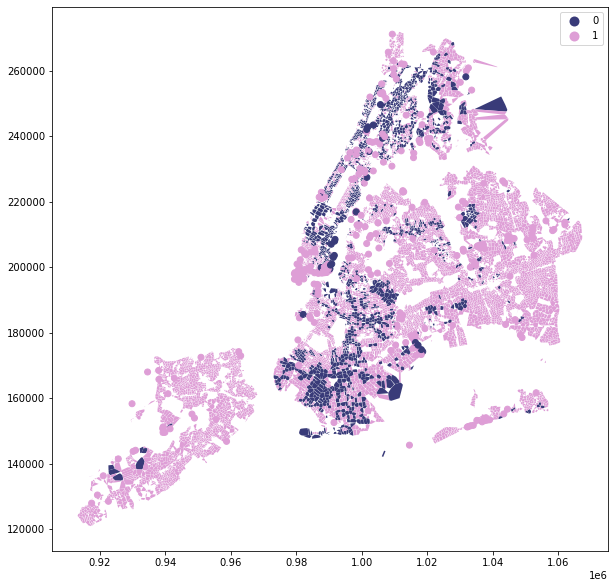

In [175]:
fig, ax = plt.subplots(1, figsize=(15,10))
k_outcomes.plot(column='cluster_k_outcome',categorical=True, ax=ax, legend=True, cmap='tab20b')

#### B. GAUSSIAN/EM

In [178]:
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=100)
    cluster_labels=clusterer.fit_predict(scaled_all)    
    silhouette_avg = silhouette_score(scaled_all, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.31479714485068533
For n_clusters = 3, the average silhouette_score is : 0.10676564975441095
For n_clusters = 4, the average silhouette_score is : 0.06943503512271293
For n_clusters = 5, the average silhouette_score is : 0.059526855527694385
For n_clusters = 6, the average silhouette_score is : 0.053459897909268285
For n_clusters = 7, the average silhouette_score is : 0.058029481822702865
For n_clusters = 8, the average silhouette_score is : 0.053572358947825686
For n_clusters = 9, the average silhouette_score is : 0.04946553979826027


Probabilities of belonging to cluster 1:
 [3.96248143e-07 0.00000000e+00 1.00000000e+00 ... 1.00000000e+00
 3.32963198e-04 1.00000000e+00]

Cluster centers:
 [[ 0.57043085  0.60792106  0.10431558  0.55659848  0.57701277  0.4722252
   0.60202768  0.52956459  0.49431452  0.49838417  0.39520328  0.23729845
   0.19217931  0.17465136  0.20559787  0.01874226  0.38117681  0.61587895
   0.18157843  0.6859939   0.57298946  0.61972354  0.41999779  0.53929064
   0.38007007  0.65434953  0.68259463  0.46033126  0.54161589  0.37904659
   0.          1.          0.          0.          0.          1.
   1.          1.          0.          1.         -1.          0.
  -1.         -1.          1.          0.          0.          0.
  -1.         -1.         -1.         -0.97102326  0.77254946  0.61101049
   0.02930218 -0.0475333   0.63519177  0.70320712  0.          0.
   0.          0.          1.          0.55563706  0.          0.31009755
   0.12293412  0.46791282  0.57499142  0.47707687  0.52246756

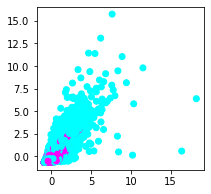

In [179]:
# Use Gaussian mixture models (EM) package from sklearn
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
gmm = GaussianMixture(n_components=2,random_state=100)
res = gmm.fit(scaled_all)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(scaled_all)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(scaled_all))

plt.figure(figsize=(3,3))
splot = plt.subplot(111)

# plot ellipses using mean and covariance matrix for each cluster
colors = ['blue','red']
for i in range(2):
    mean = res.means_[i]
    var = res.covariances_[i]
    v, w = linalg.eigh(var)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=colors[i])
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plot points and cluster assigments
plt.scatter(scaled_all[:,0],scaled_all[:,1],c=res.predict_proba(scaled_all)[:,1],cmap=plt.cm.cool)
plt.show()

In [66]:
import geopandas as gpd

In [71]:
borobox = gpd.read_file('/Users/bayerd01/Documents/ML CITIES/borobox_convex_hull.geojson')

borobox

,borobox,geometry
0,B0020,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...
10859,X4978,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


<AxesSubplot:>

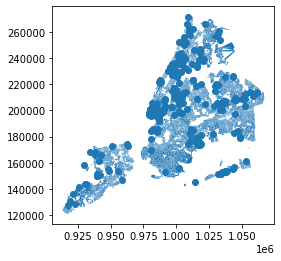

In [72]:
borobox.plot()